# Imports

In [39]:
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sympy import *
from sympy.parsing.sympy_parser import parse_expr

# Some constents

In [40]:
BOUNDARY_LINE_FUNCTION = lambda x, margin=0: 10 * x + margin  # It is just use to genrate points
BOUNDARY_LINE_MARGINE = 20
TOTAL_POINTS = 1000
POINTS_X_AXIS_BOUNDARY = np.array([-10, 10])
POINTS_Y_AXIS_BOUNDARY = np.array([-100, 100])

TEST_RATIO = 0.3
EPOCHS = 200
LEARNING_RATE = 0.0001

CLASS_A_CLR = 'red'
CLASS_B_CLR = 'blue'

# Perceptron class

In [41]:
class Perceptron:
    LEARNING_RATE = 0.01
    
    def __init__(self, input_size, learning_rate=0.01):
        self._input_dim = input_size
        self.LEARNING_RATE = learning_rate

        self._weights = np.random.rand(input_size)
        self._bias = np.random.rand()

        self._previous_weights = np.array([self._weights])
        self._previous_biases = np.array([self._bias])

    def predict(self, point):
        sum_of_product = (self._weights * point).sum() + self._bias
        return self._activation_function(sum_of_product)

    def predict_from_array(self, points):
        return np.array([self.predict(point) for point in points])
    
    def fit(self, x, y, epochs=1, mse_history=False):
        mse_arr = np.array([])

        for epoch in range(epochs):
            predicted = self.predict_from_array(x)
            self.update_weight_and_bias(x, y, predicted)

            mse = self.mean_square_error(predicted, y)
            mse_arr = np.append(mse_arr, mse)            

        if mse_history:
            return mse, mse_arr
        return mse

    def update_weight_and_bias(self, points, real, predicted):
        dw, db = self._calc_slope(points, predicted, real)

        self._weights -= dw
        self._bias -= db

        self._previous_weights = np.append(self._previous_weights, [dw], axis=0)
        self._previous_biases = np.append(self._previous_biases, db)

    # Calculate the slope/gradient of error function
    def _calc_slope(self, points, predicted, real):
        sample_size = points.shape[0]
        predicted_real_diff = predicted - real
        activation_function_derivative = self._activation_function_derivative()

        dw = (2/sample_size) * (self.LEARNING_RATE * (predicted_real_diff * activation_function_derivative)[:, None] * points).sum(0)
        db = (2/sample_size) * (self.LEARNING_RATE * (predicted_real_diff * activation_function_derivative)).sum(0)
#         print((2/sample_size) * (self.LEARNING_RATE * (predicted_real_diff * activation_function_derivative)[:, None] * points).sum(0))
        return dw, db

    def get_loss_func_equation(self, points, predicted):
        n = points.shape[0]

        # Generating loss function string
        loss_func_str = [f"""({
            '+'.join([f'{points[i, dim]}*w{dim}' for dim in range(self._input_dim)])
        }+b-{predicted[i]})**2""" for i in range(n)]

        loss_func_str = '+'.join(loss_func_str)
        loss_func_str = f'1/{n}*({loss_func_str})'

        # Simplifying equation
        loss_func_simplified = simplify(parse_expr(loss_func_str))

        weights_sym = [symbols(f'w{i}') for i in range(self._input_dim)]
        b = symbols('b')
        w, b = symbols('w b')
        loss_func_lambda = lambdify(weights_sym+[b], loss_func_simplified)
        
        return loss_func_simplified, loss_func_lambda
    
    def set_optimum_w_and_b(self, points):
        training_prediction = self.predict_from_array(points)
        loss_func_sympy, loss_func_lambda = model.get_loss_func_equation(points, training_prediction)
#         help(loss_func_lambda)
#         loss_func_sympy = parse_expr('1.0*b**2 - 0.22220484555869283*b*w0 - 2.9967489600144931*b*w1 + 0.81226747356697645*b + 33.484733622508863*w0**2 + 317.53731820451747*w0*w1 - 175.55686690440699*w0 + 5237.9721835554008*w1**2 - 4116.1365979154059*w1 + 831.1944902610262')
        import inspect
        print(loss_func_sympy)
        print(inspect.getsource(loss_func_lambda))

        weights_sym = [symbols(f'w{i}') for i in range(self._input_dim)]
        b = symbols('b')

        # First we'll find stationary points
        d_weights = [diff(loss_func_sympy, w) for w in weights_sym]
        db = diff(loss_func_sympy, b)
        stationary_points = solve(d_weights+[db], weights_sym+[b])

        self._weights = np.array([stationary_points[w] for w in weights_sym])
        self._bias = stationary_points[b]

    def mean_square_error(self, predicted, real):
        return ((predicted - real) ** 2).mean()
    
    # Calculate and return the slope and y-intercept for decision boundry
    def get_decision_boundry_m_and_b(self):
        # This method only works for 2 input perceptron
        # Todo: Have to generalize it
        m = -self._weights[0] / self._weights[1]
        b = -self._bias / self._weights[1]

        return m, b

    def _activation_function(self, input):
        # After changing the activation function
        # Also update the derivative of activation function
        # In _activation_function_derivative()
        return input
    def _activation_function_derivative(self):
        return 1
    
    # Some properties
    @property
    def weights(self):
        return self._weights
    @property
    def bias(self):
        return self._bias
    @property
    def previous_weights(self):
        return self._previous_weights
    @property
    def previous_biases(self):
        return self._previous_biases
    
# model = Perceptron(1, LEARNING_RATE)
# model.fit(X_train, y_train, epochs=EPOCHS)

# Generating training & testing points

In [42]:
np.random.seed(0)

class_a_x = np.random.uniform(POINTS_X_AXIS_BOUNDARY[0], POINTS_X_AXIS_BOUNDARY[1], TOTAL_POINTS//2)
class_a_y = np.random.uniform(BOUNDARY_LINE_FUNCTION(class_a_x, BOUNDARY_LINE_MARGINE), POINTS_Y_AXIS_BOUNDARY[1])

class_b_x = np.random.uniform(POINTS_X_AXIS_BOUNDARY[0], POINTS_X_AXIS_BOUNDARY[1], TOTAL_POINTS//2)
class_b_y = np.random.uniform(BOUNDARY_LINE_FUNCTION(class_b_x, -BOUNDARY_LINE_MARGINE), POINTS_Y_AXIS_BOUNDARY[0])

X = np.concatenate((np.stack((class_a_x, class_a_y), axis=-1), np.stack((class_b_x, class_b_y), axis=-1)))
y = np.concatenate((np.zeros(TOTAL_POINTS//2), np.ones(TOTAL_POINTS//2)))

## Plotting points

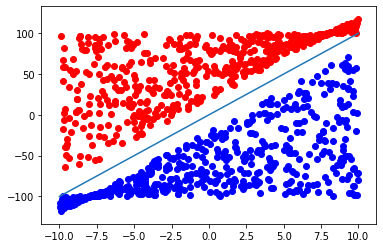

In [43]:
boundary_line_y = BOUNDARY_LINE_FUNCTION(POINTS_X_AXIS_BOUNDARY)
plt.plot(POINTS_X_AXIS_BOUNDARY, boundary_line_y)

plt.scatter(class_a_x, class_a_y, c=CLASS_A_CLR)
plt.scatter(class_b_x, class_b_y, c=CLASS_B_CLR)

## Splitting training & testing points

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_RATIO)

TOTAL_TRAIN_POINTS = X_train.shape[0]

# Training

In [45]:
model = Perceptron(2, LEARNING_RATE)

In [46]:
# _, mse_arr = model.fit(X_train, y_train, epochs=EPOCHS, mse_history=True)

## Plotting MSE

In [47]:
# fig, (plt1, plt2) = plt.subplots(1, 2)
# fig.set_figwidth(13)

# plt1.plot(np.arange(EPOCHS), mse_arr)
# plt1.set_title('Learning curve (Linear scale)')
# plt1.set_xlabel('Iterations')
# plt1.set_ylabel('MSE')
# plt1.grid(True)
# x_min, x_max, y_min, y_max = plt1.axis()
# plt1.axis((x_min, x_max, 0, y_max))
# plt1.text(0, y_max-150, f'Last MSE: {mse_arr[-1]}')

# plt2.plot(np.arange(EPOCHS), mse_arr)
# plt2.set_title('Learning curve (Logrithmic scale)')
# plt2.set_xlabel('Iterations')
# plt2.set_ylabel('MSE')
# plt2.grid(True)
# x_min, x_max, y_min, y_max = plt2.axis()
# plt2.axis((x_min, x_max, 0, y_max))
# plt2.set_xscale('log')

# Testing

In [48]:
predict = model.predict_from_array(X_test)

X_test_class_a = X_test[predict < 0]
X_test_class_b = X_test[predict >= 0]

## Plotting predictions & real data

Text(0.5, 1.0, 'True Classification')

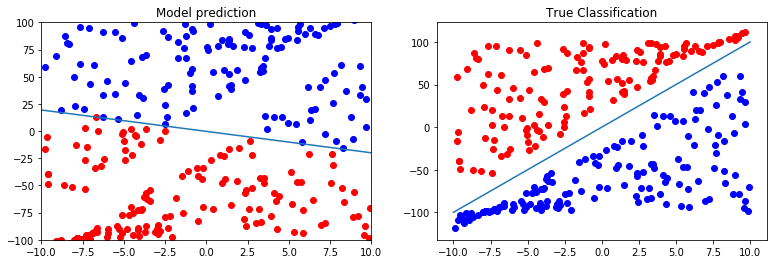

In [49]:
fig, (plot1, plot2) = plt.subplots(1, 2)
fig.set_figwidth(13)

m, b = model.get_decision_boundry_m_and_b()
boundry_line_y = (m * POINTS_X_AXIS_BOUNDARY) + b
plot1.plot(POINTS_X_AXIS_BOUNDARY, boundry_line_y)

plot1.scatter(X_test_class_a[:, 0], X_test_class_a[:, 1], c=CLASS_A_CLR)
plot1.scatter(X_test_class_b[:, 0], X_test_class_b[:, 1], c=CLASS_B_CLR)
plot1.set_title('Model prediction')
plot1.axis((POINTS_X_AXIS_BOUNDARY[0], POINTS_X_AXIS_BOUNDARY[1], POINTS_Y_AXIS_BOUNDARY[0], POINTS_Y_AXIS_BOUNDARY[1]))

plot2.scatter(X_test[y_test == 0][:, 0], X_test[y_test == 0][:, 1], c=CLASS_A_CLR)
plot2.scatter(X_test[y_test == 1][:, 0], X_test[y_test == 1][:, 1], c=CLASS_B_CLR)
plot2.plot(POINTS_X_AXIS_BOUNDARY, boundary_line_y)
plot2.set_title('True Classification')

# Tests

In [50]:
model.set_optimum_w_and_b(X_train)

1.0*b**2 + 0.5455652671180599*b*w0 + 3.0123277274806708*b*w1 - 2.3133097342440169*b + 35.596185528496962*w0**2 + 331.21586029012788*w0*w1 - 235.47202385620704*w0 + 5441.4464785219475*w1**2 - 5761.5165360170852*w1 + 1554.6968043054335
def _lambdifygenerated(w0, w1, b):
    return (1.0*b**2 + 0.5455652671180599*b*w0 + 3.0123277274806708*b*w1 - 2.3133097342440169*b + 35.596185528496962*w0**2 + 331.21586029012788*w0*w1 - 235.47202385620704*w0 + 5441.4464785219475*w1**2 - 5761.5165360170852*w1 + 1554.6968043054335)



In [51]:
model._weights = np.array([0.695181, 0.992756])
model._bias = 0.992756
# type(model._bias)
# type(np.random.rand())